In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv("dataset/creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
card_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 df 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [11]:
from sklearn.model_selection import train_test_split
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                        test_size=0.3, random_state=11, 
                                                        stratify = y_target)
    #      stratify를 사용하면 y_target의 분포를 적용해서 학습/검증용 데이터를 분류
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [12]:
# 오차행렬, 정확도, 정밀도, 재현율, F1, AUC 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬\n", confusion)
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f},\
    AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
# 로지스틱 리그레션을 적용한 모델 학습 및 평가
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
 [[85280    15]
 [   54    94]]
정확도:0.9992, 정밀도:0.8624, 재현율:0.6351, F1:0.7315,    AUC:0.9561


In [55]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서
# 학습/예측/평가 수행

def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [16]:
from lightgbm import LGBMClassifier
#                                       leaves를 구성할수있는 샘플 수
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64,\
                         n_jobs = -1, boost_from_average = False)
# 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로
# 파라미터 설정(default=True), default 설정은 재현율,AUC 성능을 매우 크게 저하시킴

get_model_train_eval(model=lgbm_clf, df=card_df)

오차 행렬
 [[85289     6]
 [   28   120]]
정확도:0.9996, 정밀도:0.9524, 재현율:0.8108, F1:0.8759,    AUC:0.9806


### 데이터 분포도 변환 후 모델 학습/예측/평가

<AxesSubplot:xlabel='Amount', ylabel='Density'>

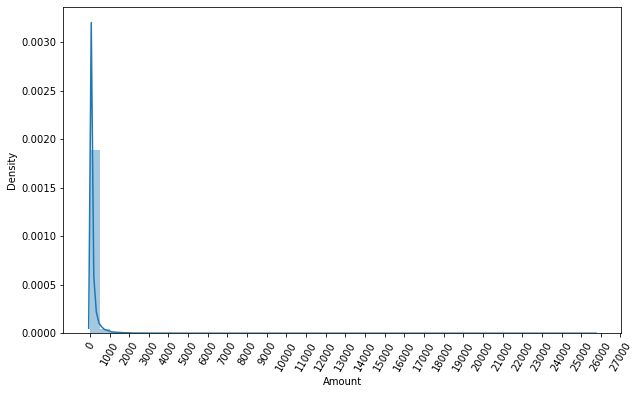

In [17]:
import seaborn as sns

plt.figure(figsize=(10,6))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [18]:
card_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [25]:
# 사이킷런의 StandardScaler를 이용해서 정규분포 형태로 Amount 피처값을 변환하는
# 로직으로 수정
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    # 2차원으로 변경
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    #변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0,'Amount_Scaled',amount_n) # Amount_Scaled 컬럼 값으로 amount_m값 입력
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [26]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, card_df)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, card_df)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85281    14]
 [   53    95]]
정확도:0.9992, 정밀도:0.8716, 재현율:0.6419, F1:0.7393,    AUC:0.9796
### LightGBM 예측 성능 ###
오차 행렬
 [[85289     6]
 [   28   120]]
정확도:0.9996, 정밀도:0.9524, 재현율:0.8108, F1:0.8759,    AUC:0.9792


In [32]:
# 넘파이의 np.log1p()를 이용해서 Amount를 로그변환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [33]:
# Amount를 로그변환 후 로지스틱 회귀 및 LightGBM 수행

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, card_df)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, card_df)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85280    15]
 [   53    95]]
정확도:0.9992, 정밀도:0.8636, 재현율:0.6419, F1:0.7364,    AUC:0.9794
### LightGBM 예측 성능 ###
오차 행렬
 [[85289     6]
 [   28   120]]
정확도:0.9996, 정밀도:0.9524, 재현율:0.8108, F1:0.8759,    AUC:0.9815


### 이상치 데이터 제거 후 모델 학습/예측/평가

<AxesSubplot:>

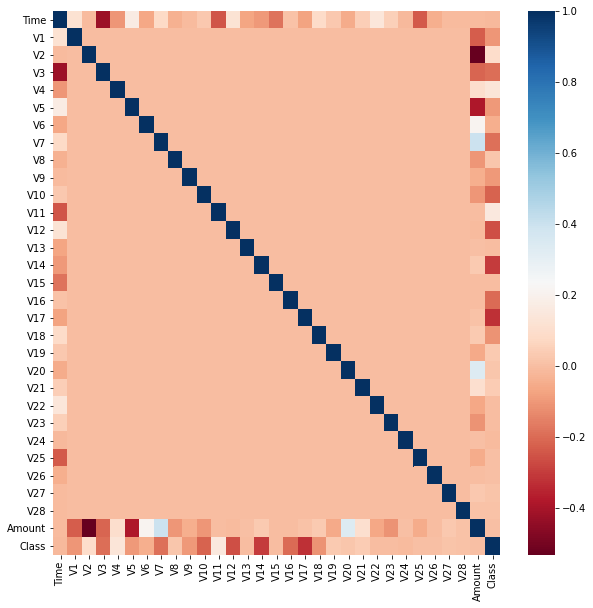

In [36]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')

In [46]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을
    # np.percentile로 구함
    
    fraud = df[df.Class==1][column]
    qt_25 = np.percentile(fraud.values, 25)
    qt_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함.
    iqr = qt_75 - qt_25
    iqr_weight = iqr*weight
    lowest_val = qt_25 - iqr_weight
    highest_val = qt_75 + iqr_weight
    
    # 최대값보다 크거나, 최소값보다 작은 값을 아웃라이어로 설정하고
    # DataFrame index 반환하기
    
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    
    return outlier_index

In [47]:
# 이상치 데이터 인덱스 출력
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print("이상치 데이터 인덱스:", outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [49]:
# get_processed_df()를 로그 변환 후 
# V14 피처의 이상치 데이터를 삭제하는 로직으로 변경

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis=0,inplace=True)
    return df_copy

# Amount를 로그변환 후 로지스틱 회귀 및 LightGBM 수행

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, card_df)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, card_df)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[85279    16]
 [   49    97]]
정확도:0.9992, 정밀도:0.8584, 재현율:0.6644, F1:0.7490,    AUC:0.9701
### LightGBM 예측 성능 ###
오차 행렬
 [[85288     7]
 [   32   114]]
정확도:0.9995, 정밀도:0.9421, 재현율:0.7808, F1:0.8539,    AUC:0.9753


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [ ]:
# imbalanced-learn 설치
# conda install -c conda-forge imbalanced-learn

In [50]:
from imblearn.over_sampling import SMOTE

In [54]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전:',X_train.shape, y_train.shape)
print('SMOTE 적용 후:',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())
# 원본 데이터는 0값 284315, 1값이 492로 매우 불균형했지만 
# SMOTE 오버샘플링으로 이를 보완해주었다.

SMOTE 적용 전: (199364, 29) (199364,)
SMOTE 적용 후: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [58]:
from sklearn.linear_model import LogisticRegression
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

# print('### LightGBM 예측 성능 ###')
# get_model_train_eval(lgbm_clf, card_df)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
 [[83669  1626]
 [   13   135]]
정확도:0.9808, 정밀도:0.0767, 재현율:0.9122, F1:0.1414,    AUC:0.9823


In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    plt.figure(figsize=(10,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary],\
             linestyle='--',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlabel('Threshold value') ; plt.ylabel('Precision and Recall value')
    plt.legend() ; plt.grid()
    plt.show()

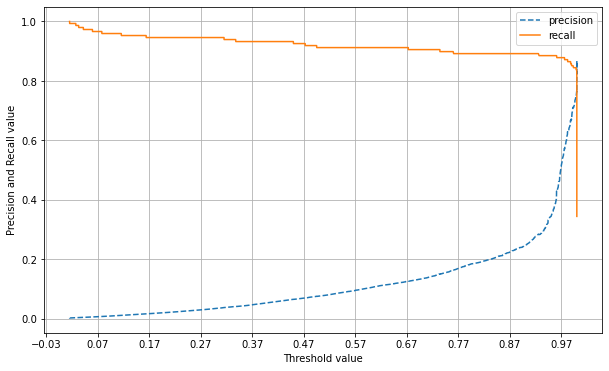

In [68]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [71]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1,\
                         boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test =X_test,\
                    tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
 [[85282    13]
 [   23   125]]
정확도:0.9996, 정밀도:0.9058, 재현율:0.8446, F1:0.8741,    AUC:0.9885


In [ ]:
SMOTE를 적용하면 재현율은 높아지지만 정밀도는 낮아지는 것이 일반적이며
좋은 SMOTE 패키지일수록 재현율을 개선하고 정밀도 감소율은 낮출 수 있도록
효과적으로 데이터를 증식한다.